# Linear and Non-Linear Models 
## ADSP 31010 | Winter 2024
### Final Project - Stage 3: Gym Membership Churn
### Group 6: Roselyn R., Mathew S., and Simran K. 

##### **Project Overview:**

The goal is to explore a commercial gym's data set to predict member churn. Classification models will be applied like logistic regression and random forest, as well as explanatory AI approaches like EBM. Basically, we want to identify trends in the data that help inform on gym members likely to churn. By doing so, the gym can address them to try and prevent customers from churning.

##### **Data Dictionary (Descriptions From Data Source):**

*User data for the preceding month:*
- 'gender' - 0 for male, 1 for female
- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located  
- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)  
- 'Promo_friends' — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)  
- 'Phone' — whether the user provided their phone number  
- 'Age' - current age of the member in years
- 'Lifetime' — the time (in months) since the customer first came to the gym  

*Data from the log of visits and purchases and data on current membership status:*
- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year  
- 'Month_to_end_contract' — the months remaining until the contract expires  
- 'Group_visits' — whether the user takes part in group sessions  
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime  
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month  
- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.
- 'Churn' — 1 if member churned, 0 if member is still active

**Data Source:** https://www.kaggle.com/datasets/ellanihill/model-fitness-customer-churn

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from statsmodels.genmod import families
from statsmodels.formula.api import glm
from interpret.glassbox import ExplainableBoostingClassifier
from scipy.stats import chi2
from pygam import LogisticGAM
from interpret import show
from lime import lime_tabular

In [2]:
warnings.filterwarnings("ignore")

In [3]:
churn = pd.read_csv('gym_churn_us.csv')

# **Exploratory Data Analysis**

In [4]:
churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
print("Rows:", churn.shape[0])
print("Columns:", churn.shape[1])

Rows: 4000
Columns: 14


In [6]:
churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [8]:
print("Nulls:\n\n", churn.isnull().sum())
print("\nNulls Percentage:\n\n", (churn.isnull().sum() / len(churn)) * 100)

Nulls:

 gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Nulls Percentage:

 gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits                         0.0
Age                                  0.0
Avg_additional_charges_total         0.0
Month_to_end_contract                0.0
L

In [9]:
for column in churn.columns:
    unique = churn[column].unique()
    print(f"{column}: {unique}")

gender: [1 0]
Near_Location: [1 0]
Partner: [1 0]
Promo_friends: [1 0]
Phone: [0 1]
Contract_period: [ 6 12  1]
Group_visits: [1 0]
Age: [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
Avg_additional_charges_total: [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]
Month_to_end_contract: [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
Lifetime: [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
Avg_class_frequency_total: [0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]
Avg_class_frequency_current_month: [0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]
Churn: [0 1]


In [10]:
n = len(churn)
churn_count = churn.loc[churn['Churn'] == 1, 'Churn'].sum()

print('Dataset Contains %d Records' % (n))
print('Number of Churns: %d (%0.2f%%)' % (churn_count, churn_count*100/n))

Dataset Contains 4000 Records
Number of Churns: 1061 (26.52%)


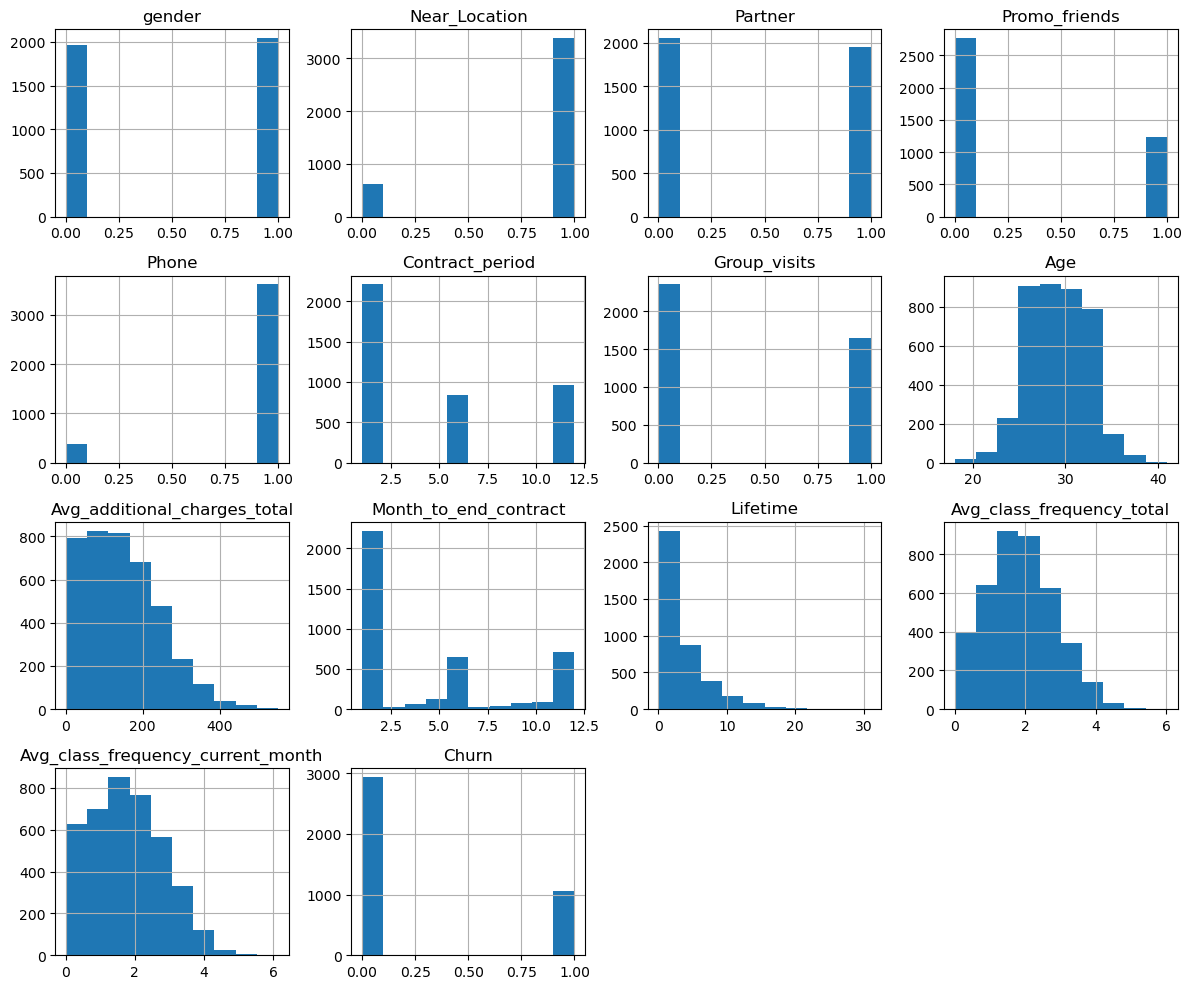

In [11]:
churn.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

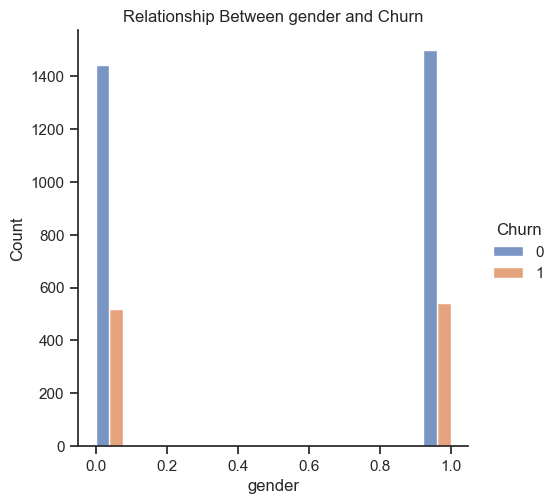

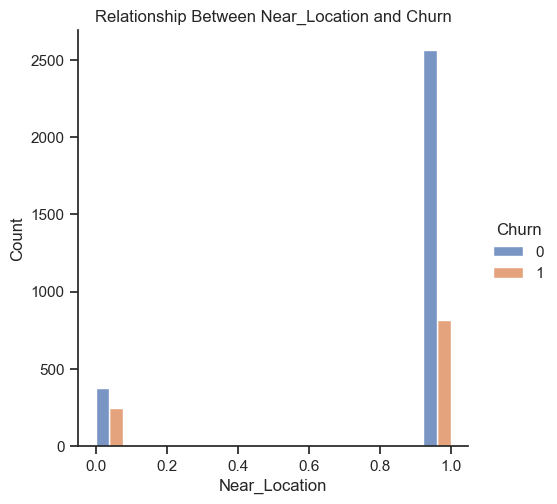

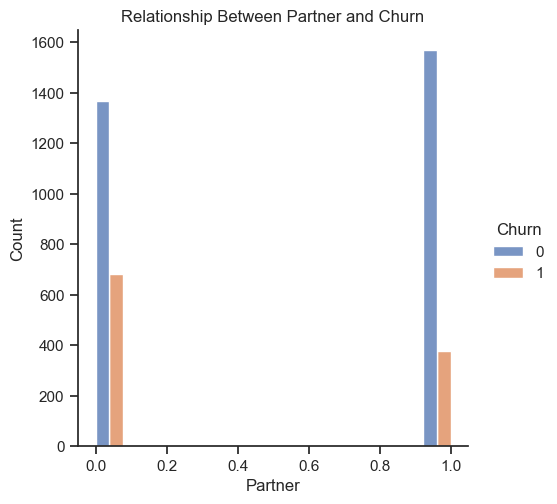

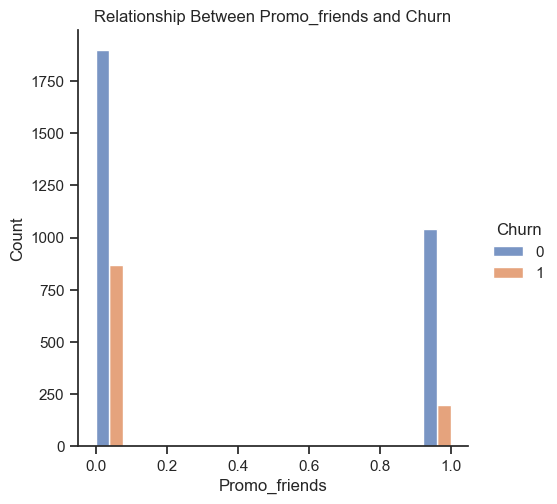

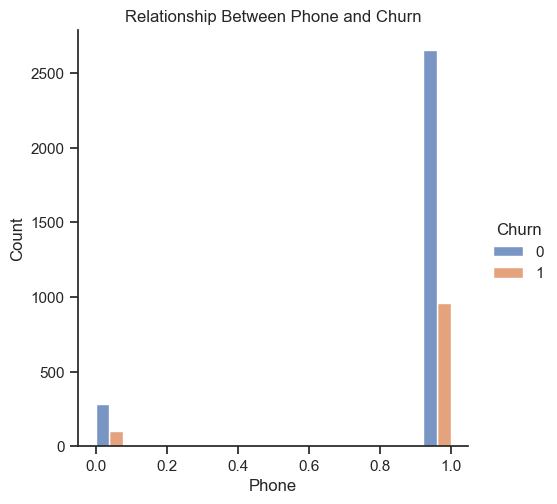

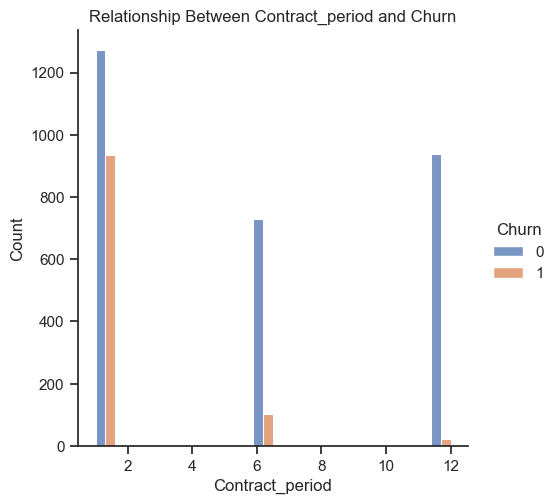

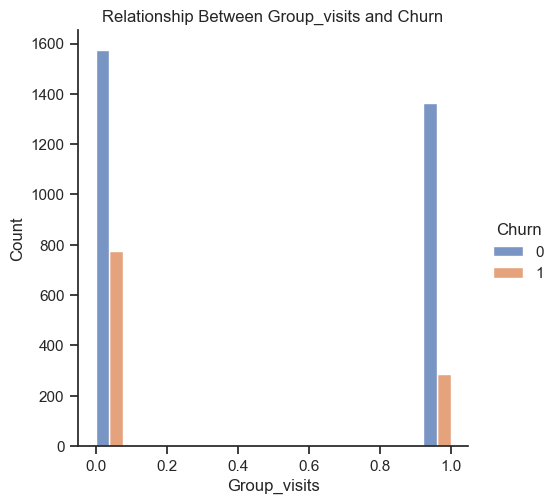

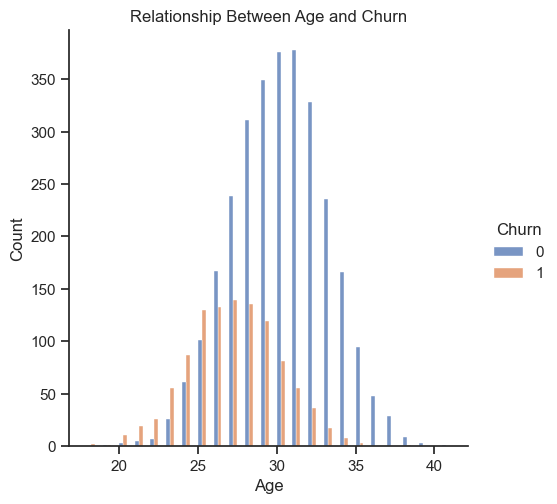

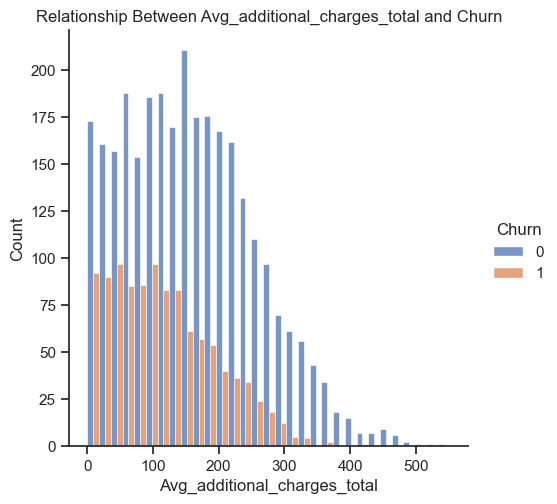

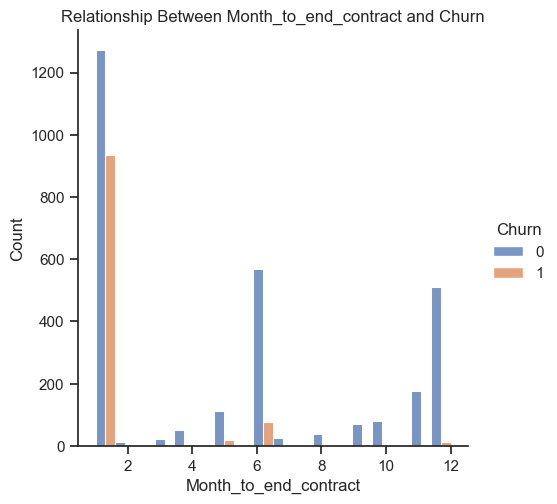

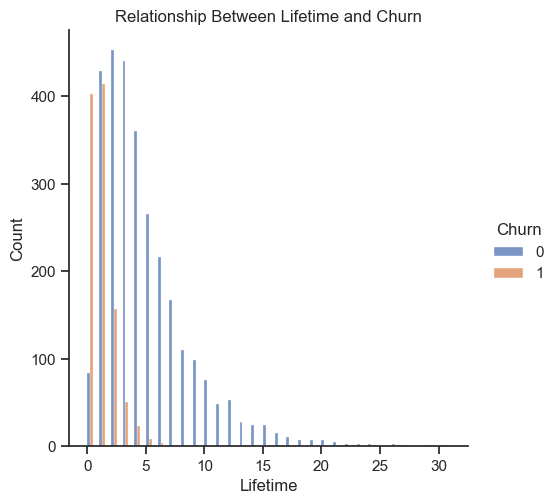

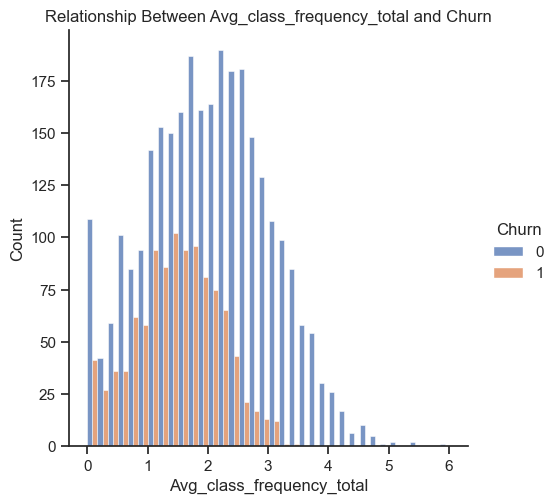

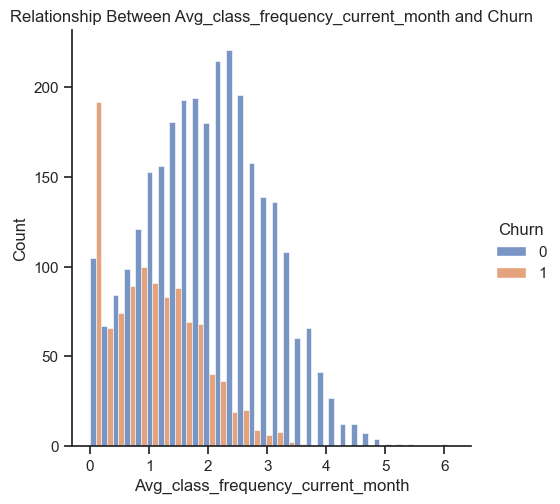

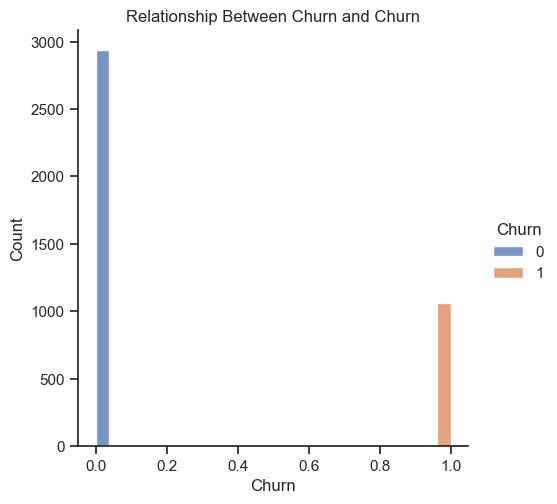

In [12]:
sns.set(style="ticks")

for column in churn.columns:
    if column != 'churn':
        sns.displot(data=churn, x=column, hue='Churn', multiple='dodge')
        plt.title(f'Relationship Between {column} and Churn')
        plt.xticks(rotation=None)
        plt.show()

In [13]:
churn.groupby('Churn').mean().round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


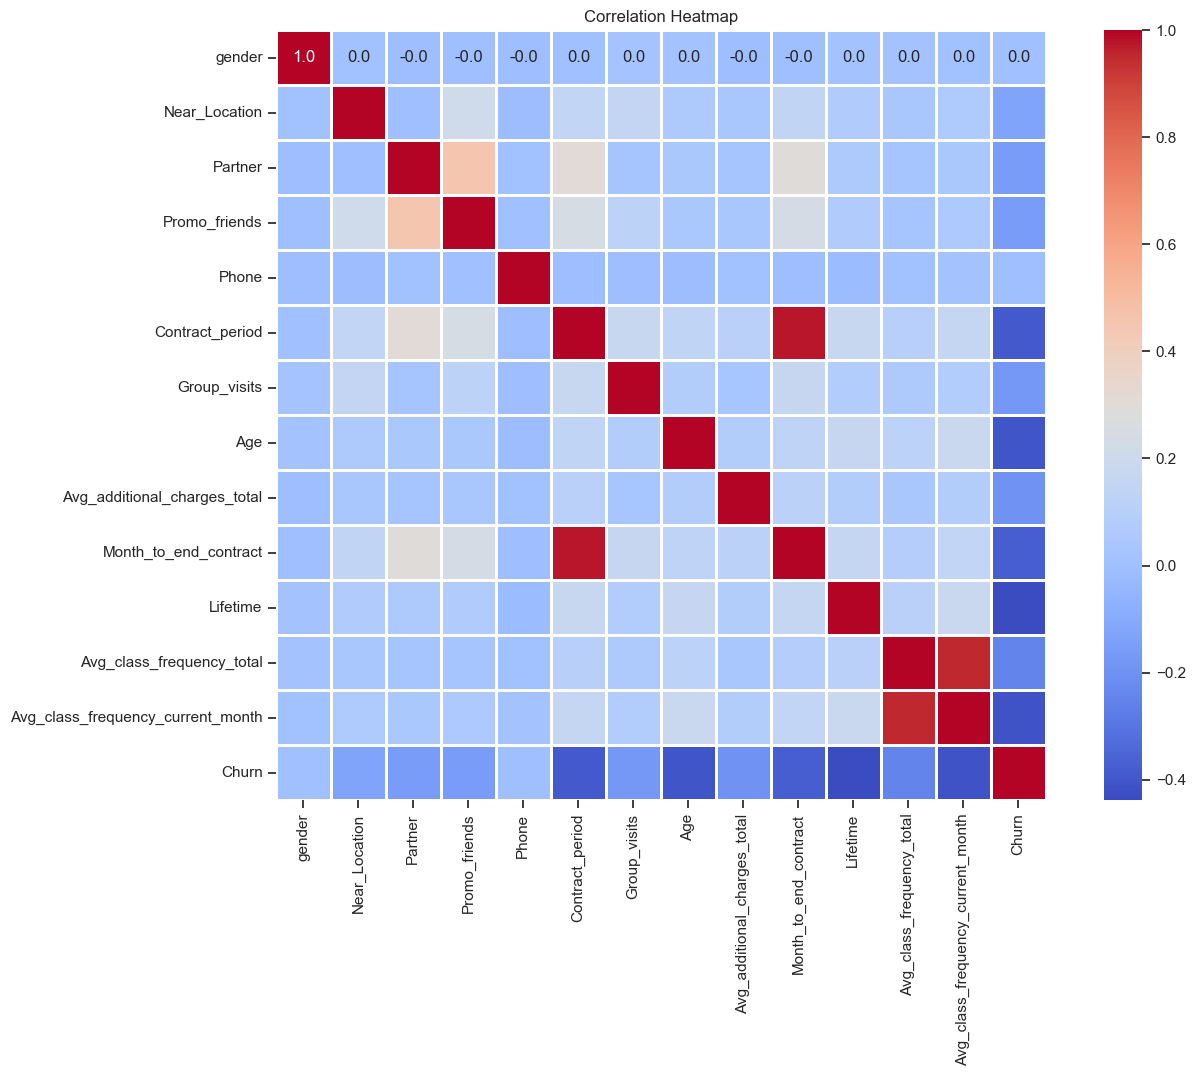

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(churn.corr(), annot=True, square=True, fmt='.1f', cmap='coolwarm', linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

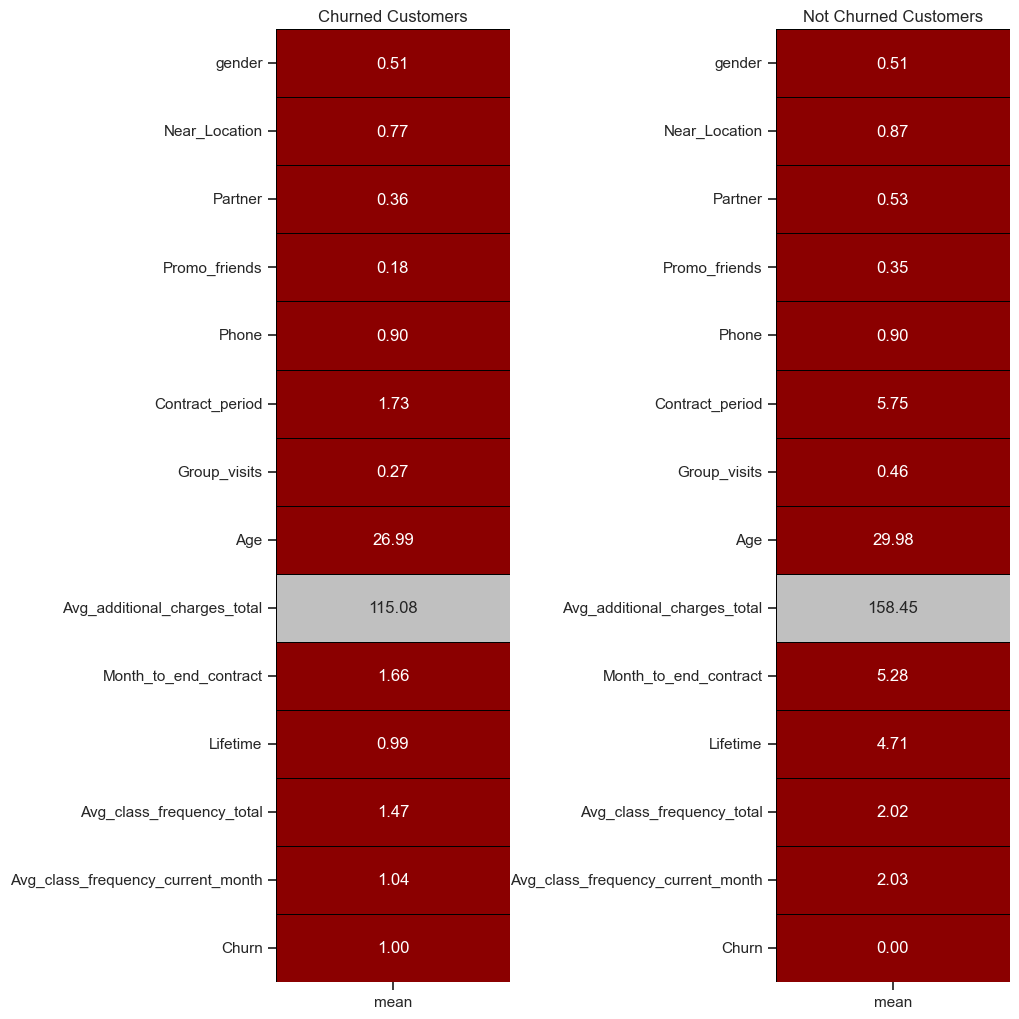

In [15]:
colors = ['#8B0000', '#C0C0C0']

churns = churn[churn['Churn'] == 1].describe().T
no_churns = churn[churn['Churn'] == 0].describe().T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

plt.subplot(1, 2, 1)
sns.heatmap(churns[['mean']], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('Churned Customers');

plt.subplot(1, 2, 2)
sns.heatmap(no_churns[['mean']], annot=True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('Not Churned Customers');

fig.tight_layout(pad=0)
plt.show()

# **Linear and Non-Linear Models**

In [16]:
X = churn.drop('Churn', axis = 1)
y = churn['Churn']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
model = LogisticRegression()

In [19]:
scale = StandardScaler()
scale.fit(X_train)
X_train_scaled = scale.transform(X_train)
X_test_scaled = scale.transform(X_test)

In [20]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [21]:
predict_logistic = model.predict(X_test_scaled)

In [22]:
accuracy_logistic = accuracy_score(y_test, predict_logistic)
precision_logistic = precision_score(y_test, predict_logistic)
recall_logistic = recall_score(y_test, predict_logistic)
f1_logistic = f1_score(y_test, predict_logistic)
lr_roc_auc = roc_auc_score(y_test, predict_logistic)

confusion_matrix_logistic = confusion_matrix(y_test, predict_logistic)
classification_logistic = classification_report(y_test, predict_logistic)

Intercept and Coefficients: [-3.56361856] [[ 0.11828105 -0.12976129 -0.0549053  -0.24835576 -0.00819076 -1.04623448
  -0.38593768 -1.09818663 -0.51993055 -0.2988799  -3.47155344  3.18447501
  -4.30146075]]

Accuracy is 0.925

Precision is 0.8763250883392226

 Recall is 0.8184818481848185

F1 Score:
 0.8464163822525597

ROC AUC:
 0.8897314480611941

Confusion Matrix:



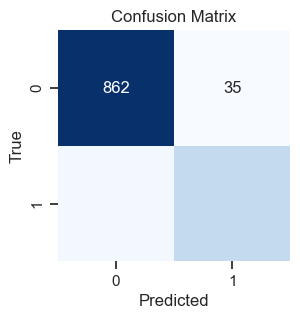


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       897
           1       0.88      0.82      0.85       303

    accuracy                           0.93      1200
   macro avg       0.91      0.89      0.90      1200
weighted avg       0.92      0.93      0.92      1200



In [23]:
print("Intercept and Coefficients:", model.intercept_, model.coef_)

print("\nAccuracy is", accuracy_logistic)

print("\nPrecision is", precision_logistic)

print("\n Recall is", recall_logistic)

print("\nF1 Score:\n", f1_logistic)

print("\nROC AUC:\n", lr_roc_auc)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_logistic, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_logistic)

Logistic Regression with RFE

In [24]:
rfe = RFE(model)
fit = rfe.fit(X_train_scaled, y_train)

print("Number of Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Number of Features: 6
Selected Features: [False False False False False  True False  True  True False  True  True
  True]
Feature Ranking: [6 5 7 4 8 1 2 1 1 3 1 1 1]


In [25]:
selected = np.array(X_train.columns)[fit.support_]
print(selected)

['Contract_period' 'Age' 'Avg_additional_charges_total' 'Lifetime'
 'Avg_class_frequency_total' 'Avg_class_frequency_current_month']


In [26]:
train_transform = rfe.transform(X_train_scaled)
test_transform = rfe.transform(X_test_scaled)

In [27]:
model.fit(train_transform, y_train)

LogisticRegression()

In [28]:
predict_logistic_test = model.predict(test_transform)
predict_logistic_train = model.predict(train_transform)

In [29]:
accuracy_logistic2 = accuracy_score(y_test, predict_logistic_test)
precision_logistic2 = precision_score(y_test, predict_logistic_test)
recall_logistic2 = recall_score(y_test, predict_logistic_test)
f1_logistic2 = f1_score(y_test, predict_logistic_test)
lr_roc_auc2 = roc_auc_score(y_test, predict_logistic_test)

confusion_matrix_logistic2 = confusion_matrix(y_test, predict_logistic_test)
classification_logistic2 = classification_report(y_test, predict_logistic_test)

Intercept and Coefficients: [-3.45696358] [[-1.46139655 -1.05309867 -0.504759   -3.44009382  3.16767765 -4.27042349]]

Accuracy is 0.9283333333333333

Precision is 0.8916967509025271

Recall is 0.8151815181518152

F1 Score:
 0.8517241379310344

ROC AUC:
 0.8908683510491517

Confusion Matrix:



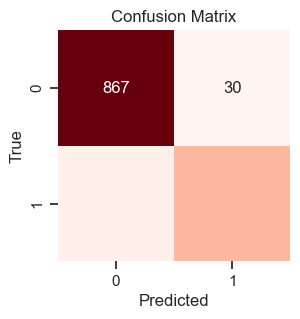


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       897
           1       0.89      0.82      0.85       303

    accuracy                           0.93      1200
   macro avg       0.92      0.89      0.90      1200
weighted avg       0.93      0.93      0.93      1200



In [30]:
print("Intercept and Coefficients:", model.intercept_, model.coef_)

print("\nAccuracy is", accuracy_logistic2)

print("\nPrecision is", precision_logistic2)

print("\nRecall is", recall_logistic2)

print("\nF1 Score:\n", f1_logistic2)

print("\nROC AUC:\n", lr_roc_auc2)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_logistic2, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_logistic2)

In [31]:
coefficients = model.coef_[0]
intercept = model.intercept_[0]

odds_ratios = np.exp(coefficients)
std_errors = np.sqrt(np.diag(np.linalg.inv(train_transform.T @ train_transform)))
z_values = coefficients / std_errors
p_values = 2 * (1 - chi2.cdf(z_values**2, df=1))

lr_summary_table = pd.DataFrame({
    'Feature': selected,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
    'Standard Error': std_errors,
    'Z-value': z_values,
    'P-value': p_values
})

print('Logistic Regression Summary Table')
lr_summary_table.round(3)

Logistic Regression Summary Table


,Feature,Coefficient,Odds Ratio,Standard Error,Z-value,P-value
0,Contract_period,-1.461,0.232,0.020,-73.945,0.0
1,Age,-1.053,0.349,0.020,-53.340,0.0
2,Avg_additional_charges_total,-0.505,0.604,0.019,-26.285,0.0
3,Lifetime,-3.440,0.032,0.020,-172.968,0.0
4,Avg_class_frequency_total,3.168,23.752,0.065,48.989,0.0
5,Avg_class_frequency_current_month,-4.270,0.014,0.066,-64.424,0.0


Logistic Regression Analysis

In [32]:
X = sm.add_constant(X)

In [33]:
glm_model = glm("y ~ X", data = churn, family=families.Binomial())
results = glm_model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3986
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -661.85
Date:                Sun, 03 Mar 2024   Deviance:                       1323.7
Time:                        09:03:45   Pearson chi2:                 5.81e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5622
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3907      0.454     16.289      0.0

In [34]:
print('\nOdds: \n', np.exp(results.params))


Odds: 
 Intercept    1620.876006
X[0]         1620.876006
X[1]            0.993333
X[2]            0.875814
X[3]            0.830280
X[4]            0.595215
X[5]            0.984586
X[6]            0.837777
X[7]            0.408187
X[8]            0.691280
X[9]            0.994189
X[10]           0.882610
X[11]           0.344559
X[12]          52.696435
X[13]           0.008624
dtype: float64


### *Non-Linear Model - Random Forest*

In [35]:
random_forest = RandomForestClassifier(n_estimators=50, random_state=42)

In [36]:
random_forest.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [37]:
predict3 = random_forest.predict(X_test_scaled)

In [38]:
accuracy_rf = accuracy_score(y_test, predict3)
precision_rf = precision_score(y_test, predict3)
recall_rf = recall_score(y_test, predict3)
f1_rf = f1_score(y_test, predict3)
rf_roc_auc = roc_auc_score(y_test, predict3)

confusion_matrix_rf = confusion_matrix(y_test, predict3)
classification_rf = classification_report(y_test, predict3)

Accuracy is 0.9166666666666666

Precision is 0.8637992831541219

Recall is 0.7953795379537953

F1 Score:
 0.8281786941580755

ROC AUC:
 0.876508052143007

Confusion Matrix:



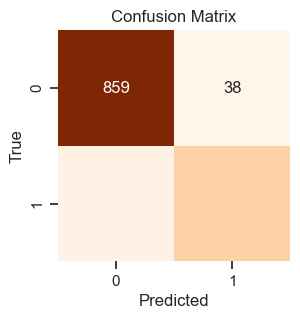


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       897
           1       0.86      0.80      0.83       303

    accuracy                           0.92      1200
   macro avg       0.90      0.88      0.89      1200
weighted avg       0.92      0.92      0.92      1200



In [39]:
print("Accuracy is", accuracy_rf)

print("\nPrecision is", precision_rf)

print("\nRecall is", recall_rf)

print("\nF1 Score:\n", f1_rf)

print("\nROC AUC:\n", rf_roc_auc)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_rf)

# **XAI Methods**

In [40]:
EBM = ExplainableBoostingClassifier()

In [41]:
EBM.fit(X_train_scaled, y_train)

ExplainableBoostingClassifier()

In [42]:
predict_EBM = EBM.predict(X_test_scaled)

In [43]:
accuracy_EBM = accuracy_score(y_test, predict_EBM)
precision_EBM = precision_score(y_test, predict_EBM)
recall_EBM = recall_score(y_test, predict_EBM)
f1_EBM = f1_score(y_test, predict_EBM)
EBM_roc_auc = roc_auc_score(y_test, predict_EBM)

confusion_matrix_EBM = confusion_matrix(y_test, predict_EBM)
classification_EBM = classification_report(y_test, predict_EBM)

Accuracy is 0.9525

Precision is 0.9270833333333334

Recall is 0.8811881188118812

F1 Score:
 0.9035532994923858

ROC AUC:
 0.9288883737872115

Confusion Matrix:



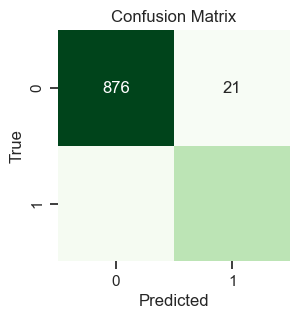


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       897
           1       0.93      0.88      0.90       303

    accuracy                           0.95      1200
   macro avg       0.94      0.93      0.94      1200
weighted avg       0.95      0.95      0.95      1200



In [44]:
print("Accuracy is", accuracy_EBM)

print("\nPrecision is", precision_EBM)

print("\nRecall is", recall_EBM)

print("\nF1 Score:\n", f1_EBM)

print("\nROC AUC:\n", EBM_roc_auc)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_EBM, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_EBM)

In [45]:
visual = EBM.explain_global()

show(visual)

<!-- http://127.0.0.1:7001/11322363024/ -->

### *Generalized Additive Models (GAMs)*

In [46]:
GAM_model = LogisticGAM().fit(X_train_scaled, y_train)

In [47]:
predict_GAM = GAM_model.predict(X_test_scaled)

In [48]:
accuracy_GAM = accuracy_score(y_test, predict_GAM)
precision_GAM = precision_score(y_test, predict_GAM)
recall_GAM = recall_score(y_test, predict_GAM)
f1_GAM = f1_score(y_test, predict_GAM)
GAM_roc_auc = roc_auc_score(y_test, predict_GAM)

confusion_matrix_GAM = confusion_matrix(y_test, predict_GAM)
classification_GAM = classification_report(y_test, predict_GAM)

Accuracy is 0.9316666666666666

Precision is 0.8850174216027874

Recall is 0.8382838283828383

F1 Score:
 0.8610169491525423

ROC AUC:
 0.9007472653619878

Confusion Matrix:



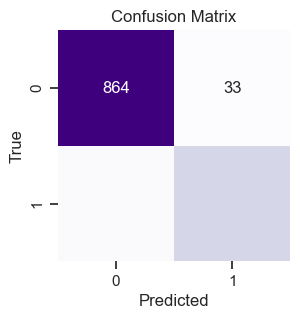


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       897
           1       0.89      0.84      0.86       303

    accuracy                           0.93      1200
   macro avg       0.92      0.90      0.91      1200
weighted avg       0.93      0.93      0.93      1200



In [49]:
print("Accuracy is", accuracy_GAM)

print("\nPrecision is", precision_GAM)

print("\nRecall is", recall_GAM)

print("\nF1 Score:\n", f1_GAM)

print("\nROC AUC:\n", GAM_roc_auc)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_GAM, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_GAM)

### *SHAP (SHapley Additive exPlanations)*

Logistic Regression with SHAP

In [50]:
X_train_rfe_df = pd.DataFrame(train_transform, columns=selected) 
X_train_rfe_df

,Contract_period,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1.605430,-0.053372,0.082801,-0.459928,1.191509,1.105587
1,0.290915,-0.053372,-0.969705,0.081619,0.184635,0.302217
2,1.605430,-0.358981,-0.655765,-1.001476,-1.931423,-1.672263
3,-0.804515,0.252237,-1.071021,0.352393,-0.870048,-0.768089
4,1.605430,0.863454,1.063201,-1.001476,0.020532,0.260950
...,...,...,...,...,...,...
2795,0.290915,-0.358981,-0.929097,-0.459928,0.754209,0.842038
2796,-0.804515,-0.053372,-0.099403,-0.730702,0.226725,0.471455
2797,-0.804515,-0.358981,-1.183133,-0.730702,-0.517585,-0.317403
2798,1.605430,-1.581417,-1.465951,3.330903,-0.323702,0.047957


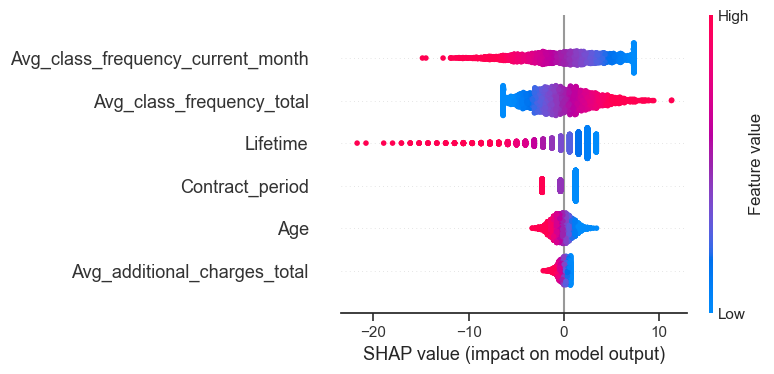

In [51]:
explainer_lr = shap.Explainer(model, X_train_rfe_df)

shap_values_lr = explainer_lr.shap_values(X_train_rfe_df)

shap.summary_plot(shap_values_lr, X_train_rfe_df)

Commentary:

- Y-axis displays the feature names (from most important to least important, top to bottom)
- X-axis displays the SHAP value (this represents the degree of change in log odds)
- The color of each point on the graph represents the value of the corresponding feature (red = high values = more likely to churn, blue = low values = less likely to churn)
- Each point is a row of data from our dataset
- As shown in the SHAP summary plot above, 'Avg_class_frequency_current_month" was the most important feature in the logistic regression model, followed by 'Avg_class_frequency_total". Focusing on the 'Avg_class_frequency_current_month" feature, we see that it is mostly high-value observations with a negative SHAP value. This means having a higher class frequency in the current month tends to reduce the likelihood that the member will churn. 

In [52]:
sample_instance = X_train_rfe_df.iloc[0]
shap_values_lr_sample = explainer_lr.shap_values(sample_instance)
shap.initjs()
shap.force_plot(explainer_lr.expected_value, shap_values_lr_sample, sample_instance)

Commentary:

Features that push the model prediction towards "churn" are red, while features that push the prediction towards "not churn" are blue. Picking the first row in our training data, our logistic regression model predicted this member would not churn. Looking at the SHAP values explains how the model came to this classification.

This member's average class frequency over the life of their membership was a primary contributor suggesting this member might churn. However, the model ultimately predicted the member would not churn given their: 1) frequency of class attendance in the current month; and 2) contract period.

In [53]:
summary_shap = pd.DataFrame(shap_values_lr, columns=X_train_rfe_df.columns)
summary_shap2 = summary_shap.describe().transpose().round(3)
summary_shap2

,count,mean,std,min,25%,50%,75%,max
Contract_period,2800.0,0.092,1.462,-2.254,-0.333,1.268,1.268,1.268
Age,2800.0,-0.140,1.053,-3.302,-0.727,-0.084,0.560,3.457
Avg_additional_charges_total,2800.0,-0.010,0.505,-2.152,-0.342,0.044,0.398,0.763
Lifetime,2800.0,-0.017,3.441,-21.722,-1.230,0.633,2.496,3.428
Avg_class_frequency_total,2800.0,-0.252,3.168,-6.370,-2.505,-0.379,1.859,11.368
Avg_class_frequency_current_month,2800.0,0.250,4.271,-14.853,-2.698,0.429,3.514,7.391


### *LIME (Local Interpretable Model-Agnostic Explanations)*

Random Forest with LIME

In [54]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [55]:
explainer_lime = lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X_train.columns, class_names=churn['Churn'].unique(), discretize_continuous=True)

In [56]:
sample_idx = 0
explanation = explainer_lime.explain_instance(X_test_scaled[sample_idx], rf_model.predict_proba, num_features=4)

In [57]:
print("Actual Class:", y_test[sample_idx])
print("Predicted Class:", rf_model.predict([X_test_scaled[sample_idx]])[0])
explanation.show_in_notebook()

Actual Class: 0
Predicted Class: 0


In [58]:
predictions = rf_model.predict(X_test_scaled)

In [59]:
accuracy_lime = accuracy_score(y_test, predictions)
precision_lime = precision_score(y_test, predictions)
recall_lime = recall_score(y_test, predictions)
f1_lime = f1_score(y_test, predictions)
lime_roc_auc = roc_auc_score(y_test, predictions)

confusion_matrix_lime = confusion_matrix(y_test, predictions)
classification_lime = classification_report(y_test, predictions)

Accuracy is 0.9166666666666666

Precision is 0.8637992831541219

Recall is 0.7953795379537953

F1 Score:
 0.8281786941580755

ROC AUC:
 0.876508052143007

Confusion Matrix:



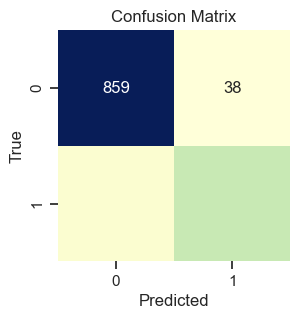


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       897
           1       0.86      0.80      0.83       303

    accuracy                           0.92      1200
   macro avg       0.90      0.88      0.89      1200
weighted avg       0.92      0.92      0.92      1200



In [60]:
print("Accuracy is", accuracy_lime)

print("\nPrecision is", precision_lime)

print("\nRecall is", recall_lime)

print("\nF1 Score:\n", f1_lime)

print("\nROC AUC:\n", lime_roc_auc)

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_lime, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_lime)

### *Models Comparison Table*

In [61]:
dataframe = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Logistic Regression': [accuracy_logistic, precision_logistic, recall_logistic, f1_logistic, lr_roc_auc],      
    'Logistic Regression with RFE': [accuracy_logistic2, precision_logistic2, recall_logistic2, f1_logistic2, lr_roc_auc2],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf, rf_roc_auc],
    'EBM': [accuracy_EBM, precision_EBM, recall_EBM, f1_EBM, EBM_roc_auc],
    'GAM': [accuracy_GAM, precision_GAM, recall_GAM, f1_GAM, GAM_roc_auc]
}

table = pd.DataFrame(dataframe)
table.round(2)

,Metric,Logistic Regression,Logistic Regression with RFE,Random Forest,EBM,GAM
0,Accuracy,0.92,0.93,0.92,0.95,0.93
1,Precision,0.88,0.89,0.86,0.93,0.89
2,Recall,0.82,0.82,0.80,0.88,0.84
3,F1 Score,0.85,0.85,0.83,0.90,0.86
4,ROC AUC,0.89,0.89,0.88,0.93,0.90


# **Chosen Model**
## Combination of Linear and Non-Linear Techniques with Explainable AI
Logistic Regression with RFE, Random Forest and EBM

In [62]:
lr = LogisticRegression()
rfe_model = RFE(lr)
rfe_fit = rfe_model.fit(X_train_scaled, y_train)

In [63]:
X_train_rfe = rfe_model.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe_model.transform(X_test_scaled)

In [64]:
selected = np.array(X_train.columns)[rfe_fit.support_]

In [65]:
model1 = LogisticRegression()
model2 = RandomForestClassifier(n_estimators=50, random_state=42)
model3 = ExplainableBoostingClassifier()

In [66]:
combined_model = VotingClassifier(
    estimators=[('lr', model1), ('rf', model2), ('ebm', model3)],
    voting='hard'
)

combined_model.fit(X_train_rfe, y_train)

combined_model_predictions = combined_model.predict(X_test_rfe)

In [67]:
accuracy_combined = accuracy_score(y_test, combined_model_predictions)
precision_combined = precision_score(y_test, combined_model_predictions)
recall_combined = recall_score(y_test, combined_model_predictions)
f1_combined = f1_score(y_test, combined_model_predictions)
combined_roc_auc = roc_auc_score(y_test, combined_model_predictions)

confusion_matrix_combined = confusion_matrix(y_test, combined_model_predictions)
classification_combined = classification_report(y_test, combined_model_predictions)

Accuracy is 0.9375

Precision is 0.9014084507042254

Recall is 0.8448844884488449

F1 Score:
 0.8722316865417377

ROC AUC:
 0.9068346633994502

Mean Squared Error: 0.0625

Confusion Matrix:



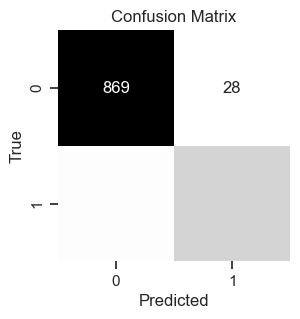


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       897
           1       0.90      0.84      0.87       303

    accuracy                           0.94      1200
   macro avg       0.93      0.91      0.92      1200
weighted avg       0.94      0.94      0.94      1200



In [68]:
print("Accuracy is", accuracy_combined)

print("\nPrecision is", precision_combined)

print("\nRecall is", recall_combined)

print("\nF1 Score:\n", f1_combined)

print("\nROC AUC:\n", combined_roc_auc)

print("\nMean Squared Error:", mean_squared_error(y_test, combined_model_predictions)) 

print("\nConfusion Matrix:\n")
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix_combined, annot=True, fmt='d', cmap='Greys', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_combined)

In [69]:
ensemble_dataframe = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Ensemble Model': [accuracy_combined, precision_combined, recall_combined, f1_combined, combined_roc_auc],      
}

ensemble_table = pd.DataFrame(ensemble_dataframe)

In [70]:
table.round(2)

,Metric,Logistic Regression,Logistic Regression with RFE,Random Forest,EBM,GAM
0,Accuracy,0.92,0.93,0.92,0.95,0.93
1,Precision,0.88,0.89,0.86,0.93,0.89
2,Recall,0.82,0.82,0.80,0.88,0.84
3,F1 Score,0.85,0.85,0.83,0.90,0.86
4,ROC AUC,0.89,0.89,0.88,0.93,0.90


In [71]:
ensemble_table.round(2)

,Metric,Ensemble Model
0,Accuracy,0.94
1,Precision,0.90
2,Recall,0.84
3,F1 Score,0.87
4,ROC AUC,0.91


## Business Application

In [72]:
results = pd.DataFrame({
    'Actual Churn': y_test,
    'Predicted Churn': combined_model_predictions
})

results

,Actual Churn,Predicted Churn
555,0,0
3491,0,0
527,0,0
3925,0,0
2989,0,0
...,...,...
3856,0,0
226,0,0
1612,0,0
535,0,0


In [73]:
results2 = pd.DataFrame({
    'Churn': y_test,
    'Predicted_Churn': combined_model_predictions
})

combined_data = pd.merge(churn, results2, on='Churn')
combined_data

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,Predicted_Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
1,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
2,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
3,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
4,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957761,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1,0
2957762,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1,1
2957763,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1,0
2957764,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1,1


In [74]:
churn_predictions = combined_data[combined_data['Predicted_Churn'] == 1]
churn_predictions_drop_churn = churn_predictions.drop('Churn', axis = 1)

In [75]:
churn_predictions_drop_churn.groupby('Predicted_Churn').mean().round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Predicted_Churn,,,,,,,,,,,,,
1,0.51,0.79,0.4,0.22,0.9,2.66,0.31,27.68,125.17,2.5,1.86,1.6,1.27


In [76]:
chart_df = combined_data.groupby('Predicted_Churn').mean().round(3)
chart_df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Predicted_Churn,,,,,,,,,,,,,,
0,0.510,0.871,0.531,0.350,0.904,5.670,0.460,29.919,157.615,5.214,4.641,2.014,2.009,0.019
1,0.511,0.793,0.397,0.223,0.903,2.663,0.314,27.684,125.166,2.504,1.856,1.603,1.273,0.767


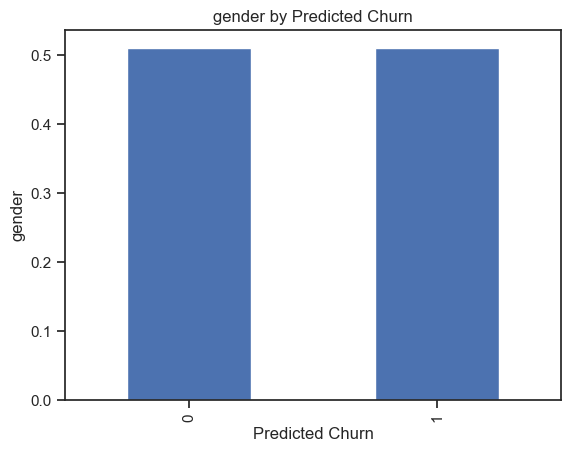

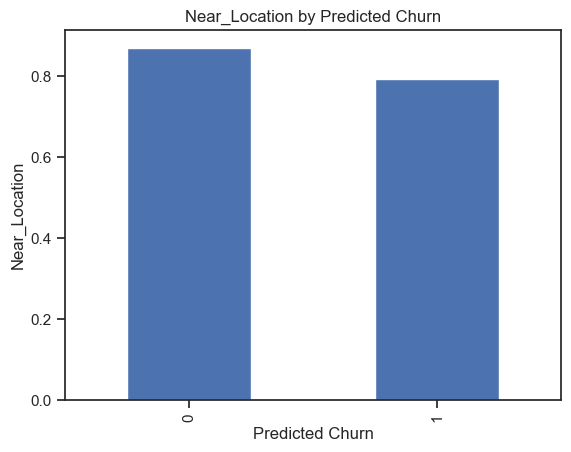

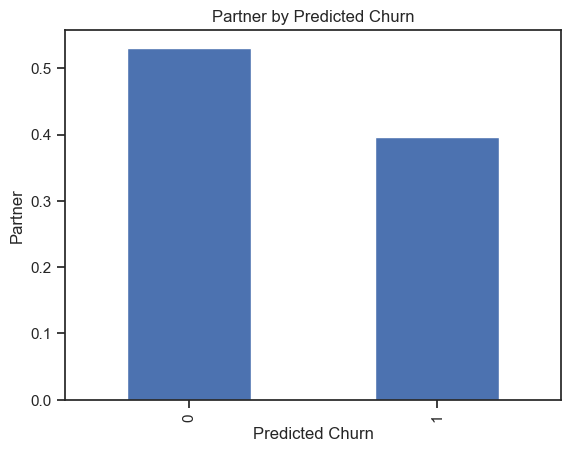

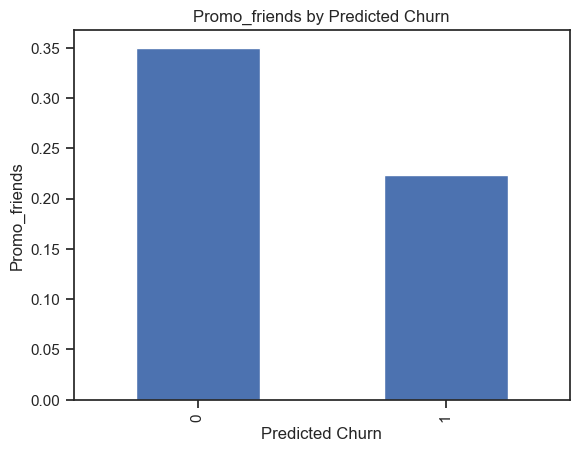

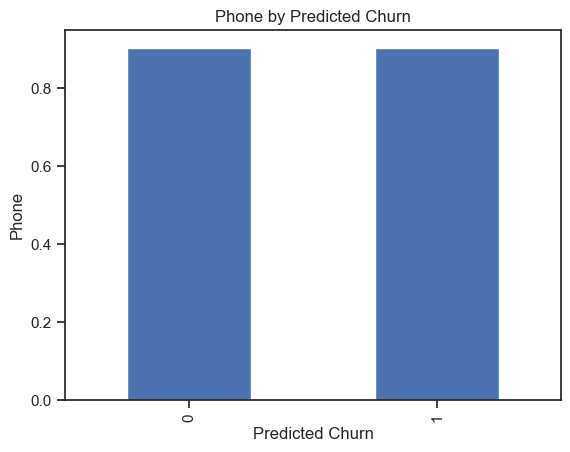

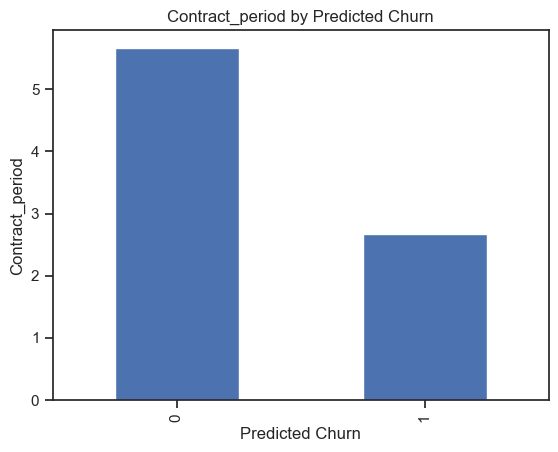

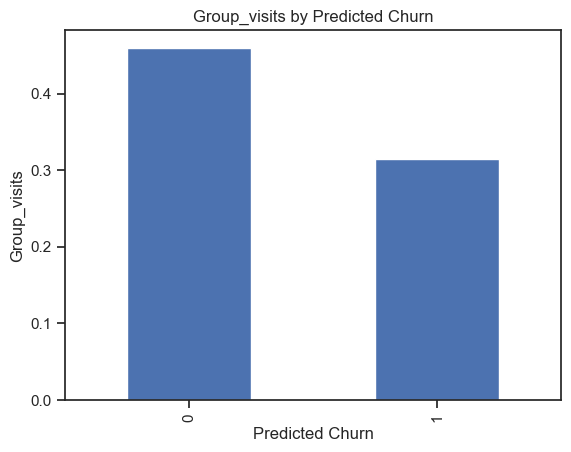

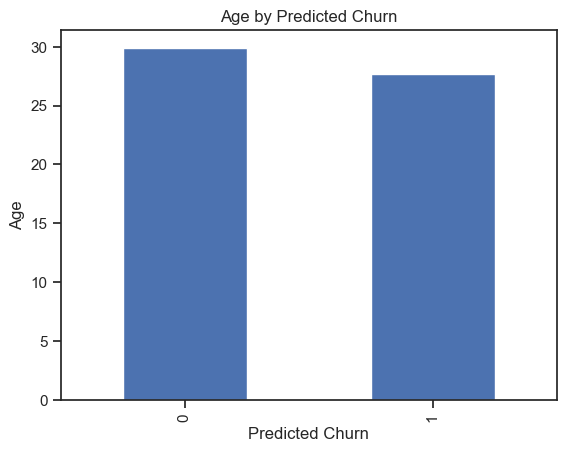

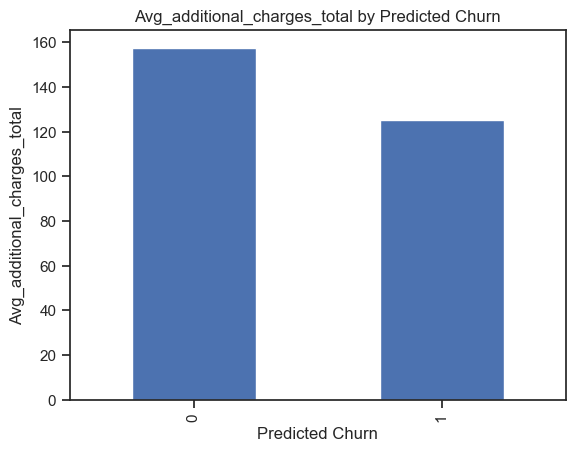

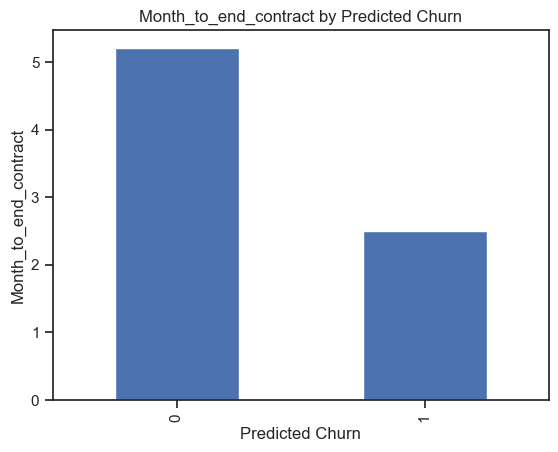

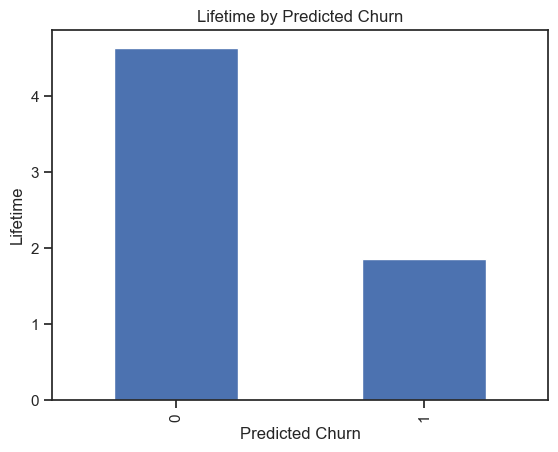

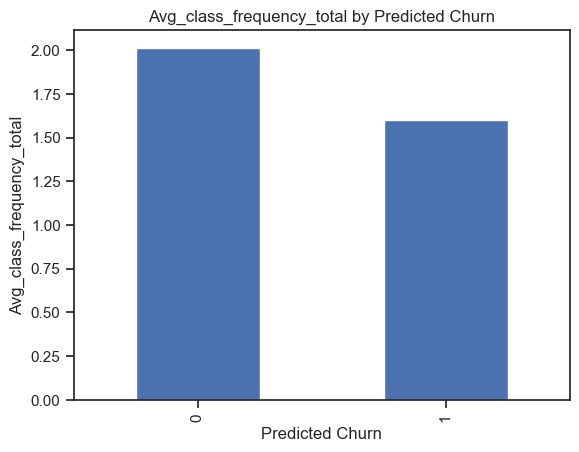

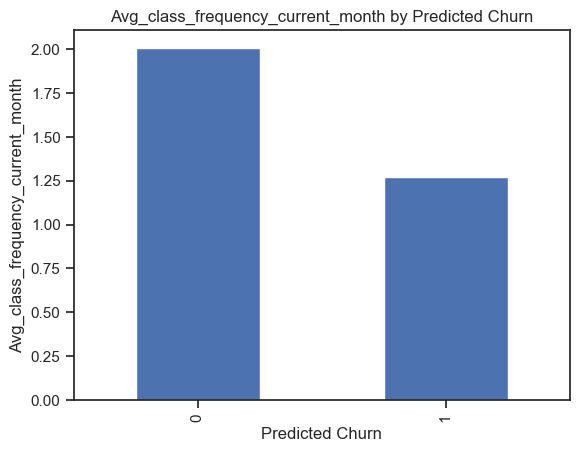

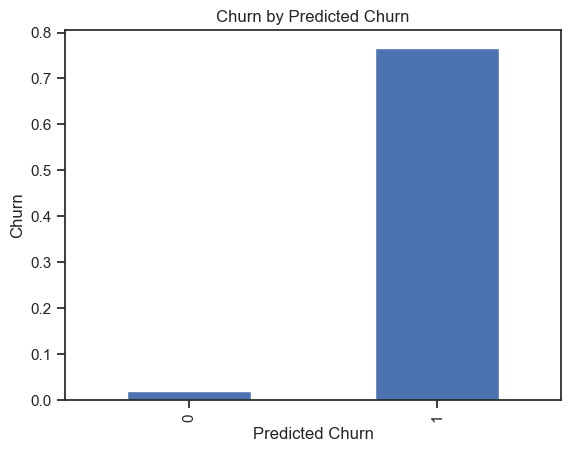

In [77]:
for column in chart_df.columns:
    if column != 'Predicted_Churn':
        plt.figure()
        chart_df[column].plot(kind='bar')
        plt.title(f'{column} by Predicted Churn')
        plt.xlabel('Predicted Churn')
        plt.ylabel(column)
        plt.show()

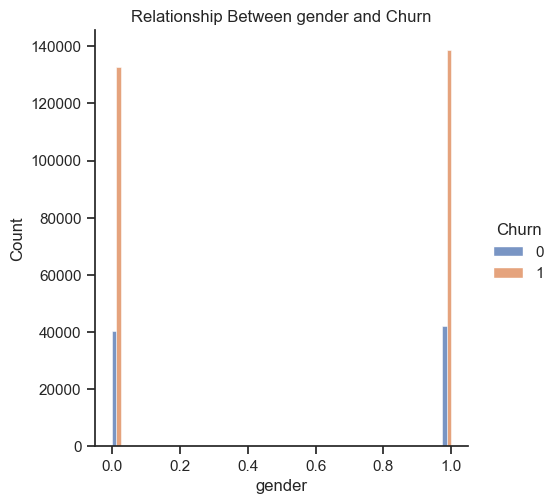

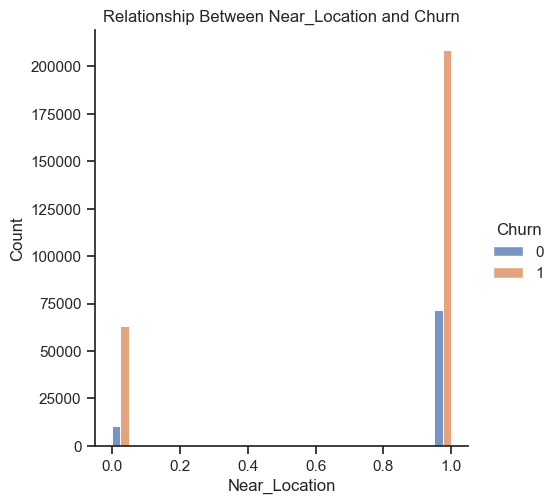

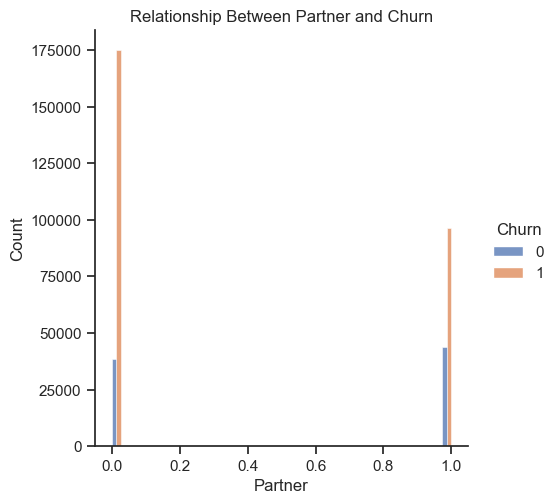

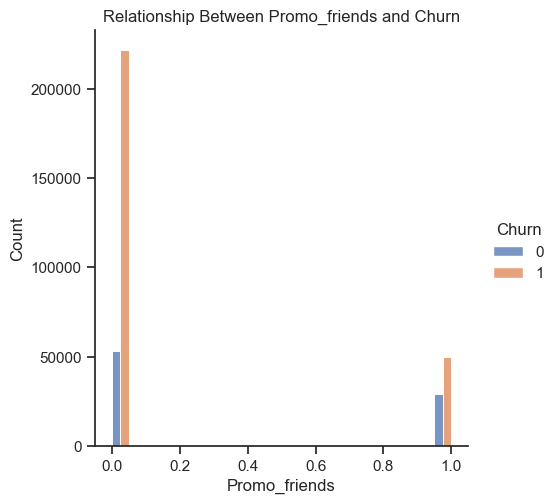

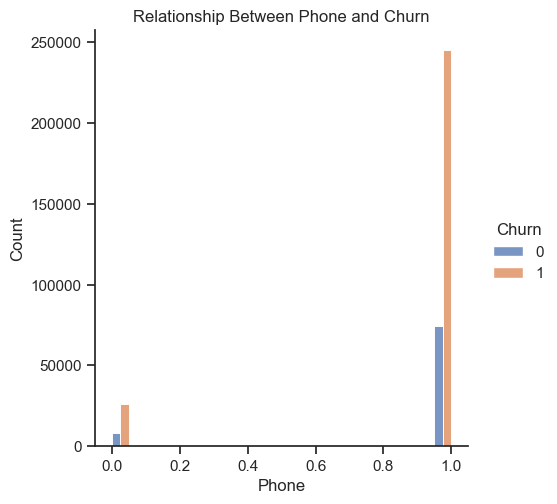

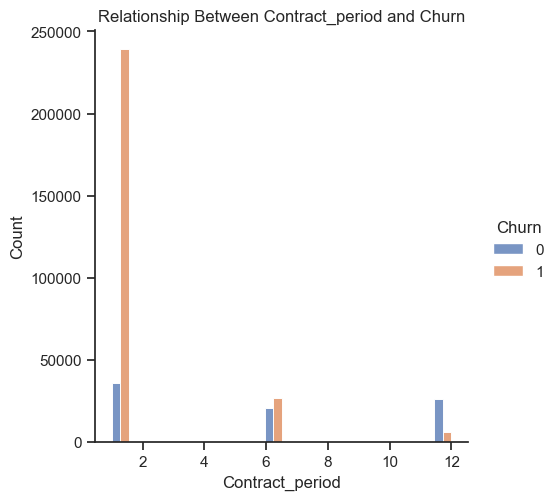

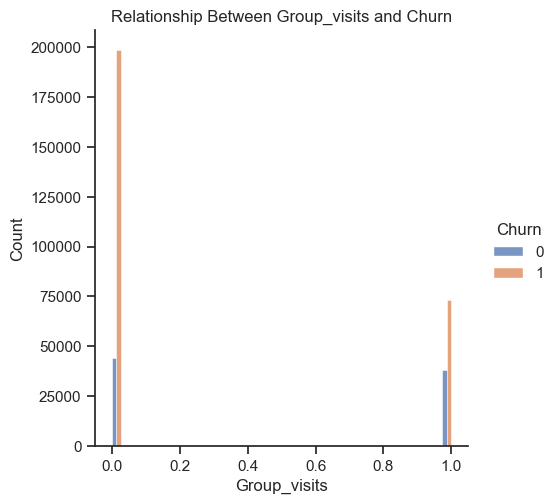

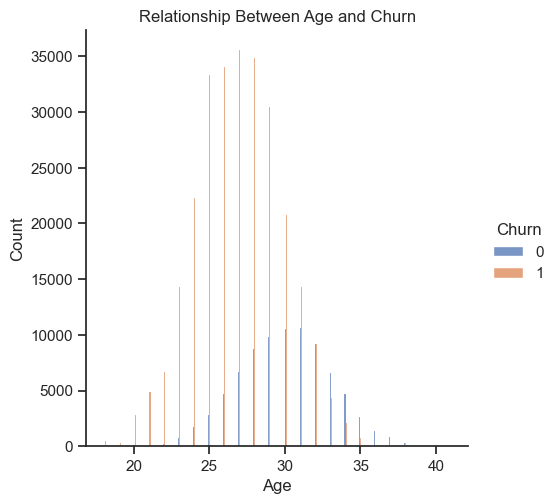

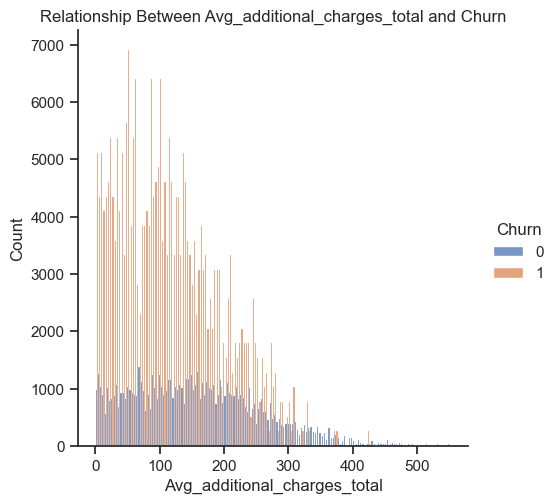

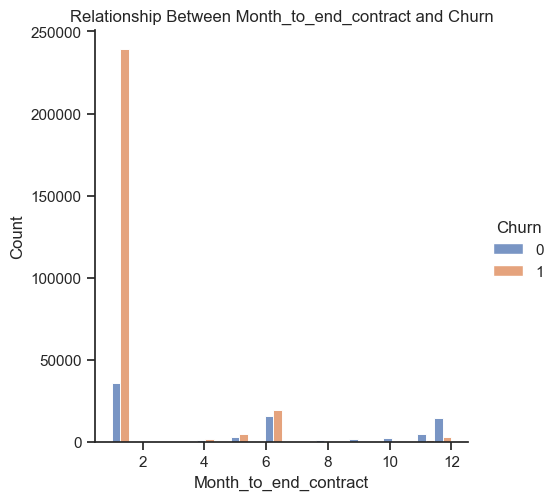

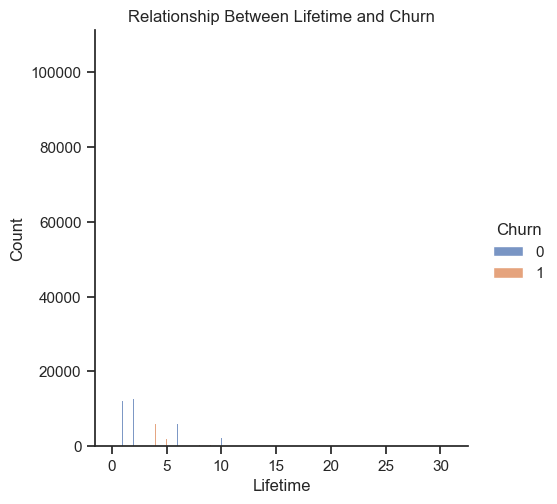

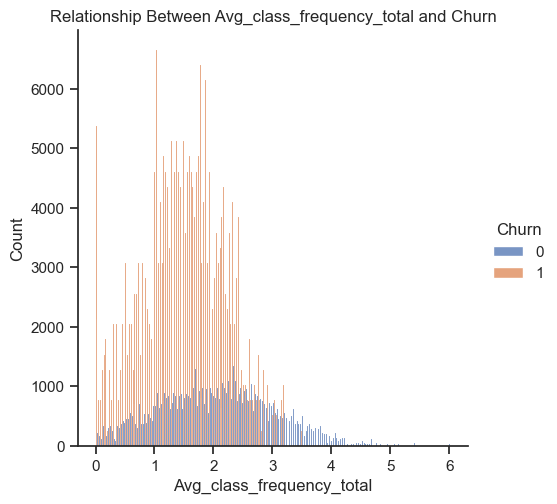

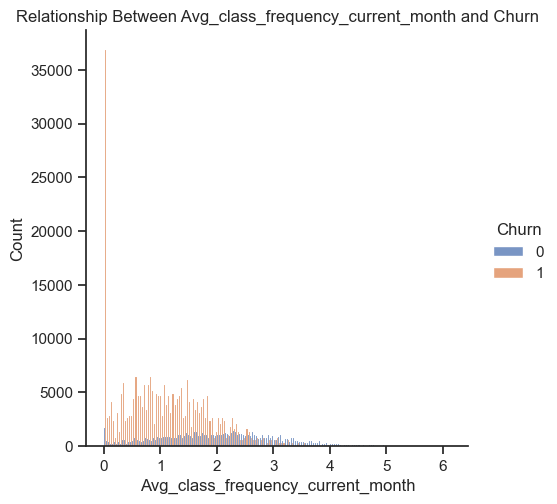

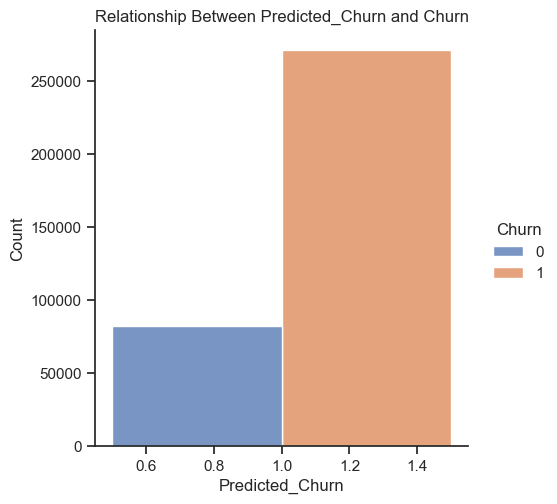

In [78]:
sns.set(style="ticks")

for column in churn_predictions.columns:
    if column != 'Churn' and 'Predicted_Churn':
        sns.displot(data=churn_predictions, x=column, hue='Churn', multiple='dodge')
        plt.title(f'Relationship Between {column} and Churn')
        plt.xticks(rotation=None)
        plt.show()

In [79]:
warnings.filterwarnings("default")